In this notebook, you'll learn how to use Apache Spark MLlib to create a machine learning application that does simple predictive analysis on an Azure open dataset. Spark provides built-in machine learning libraries. This example uses classification through logistic regression.

SparkML and MLlib are core Spark libraries that provides many utilities that are useful for machine learning tasks, including utilities that are suitable for:

Classification<BR>
Regression<BR>
Clustering<BR>
Topic modeling<BR>
Singular value decomposition (SVD) and principal component analysis (PCA)<BR>
Hypothesis testing and calculating sample statistics<BR>

In [26]:
# Import the types required for this application

import matplotlib.pyplot as plt
from datetime import datetime
from dateutil import parser
from pyspark.sql.functions import unix_timestamp, date_format, col, when
from pyspark.ml import Pipeline
from pyspark.ml import PipelineModel
from pyspark.ml.feature import RFormula
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator

StatementMeta(SparkPool01, 8, 19, Submitted, Available)

This retrieves the data via the Open Datasets API. Pulling all of this data generates about 1.5 billion rows. Depending on the size of your serverless Apache Spark pool, the raw data may be too large or take too much time to operate on. You can filter this data down to something smaller. The following code example uses start_date and end_date to apply a filter that returns a single month of data.

In [12]:
from azureml.opendatasets import NycTlcYellow

end_date = parser.parse('2018-06-06')
start_date = parser.parse('2018-05-01')
nyc_tlc = NycTlcYellow(start_date=start_date, end_date=end_date)
filtered_df = nyc_tlc.to_spark_dataframe()

StatementMeta(SparkPool01, 8, 5, Finished, Available)

The downside to simple filtering is that, from a statistical perspective, it may introduce bias into the data. Another approach is to use the sampling built into Spark. The following code reduces the dataset down to about 2000 rows, if applied after the code above. This sampling step can be used instead of the simple filter or in conjunction with the simple filter.

In [13]:
# To make development easier, faster and less expensive down sample for now
sampled_taxi_df = filtered_df.sample(True, 0.001, seed=1234)

StatementMeta(SparkPool01, 8, 6, Finished, Available)

It is normally better to review data with a subset rather than the full set depending on the size of the dataset. The following code offers two ways to view the data: the former being basic and the latter providing a much richer grid experience, as well as the capability to visualize the data graphically.

In [14]:
#sampled_taxi_df.show(5)
display(sampled_taxi_df)

StatementMeta(SparkPool01, 8, 7, Finished, Available)

SynapseWidget(Synapse.DataFrame, 4c29798b-db0e-4270-bba8-8acc67c89848)

Depending on the size of the dataset size generated, and your need to experiment or run the notebook many times, it may be advisable to cache the dataset locally in the workspace. There are three ways to perform explicit caching:

Save the dataframe locally as a file<br>
Save the dataframe as a temporary table or view<br>
Save the dataframe as a permanent table<br><br>
The first 2 of these approaches are included in the following code examples.<br>

Creating a temp table or view provides different access paths to the data, but only lasts for the duration of the Spark instance session.

In [16]:
sampled_taxi_df.createOrReplaceTempView("nytaxi")

StatementMeta(SparkPool01, 8, 9, Finished, Available)

The data in its raw form is frequently not suitable for passing directly to a model. A series of actions must be performed on the data to get it into a state where the model can consume it.

In the code below four classes of operations are performed:<BR>

The removal of outliers/incorrect values through filtering.<BR>
The removal of columns, which are not needed.<BR>
The creation of new columns derived from the raw data to make the model work more effectively, sometimes called featurization.<BR>
Labeling - since you are undertaking binary classification (will there be a tip or not on a given trip) there is a need to convert the tip amount into a 0 or 1 value.

In [17]:
taxi_df = sampled_taxi_df.select('totalAmount', 'fareAmount', 'tipAmount', 'paymentType', 'rateCodeId', 'passengerCount'\
                                , 'tripDistance', 'tpepPickupDateTime', 'tpepDropoffDateTime'\
                                , date_format('tpepPickupDateTime', 'hh').alias('pickupHour')\
                                , date_format('tpepPickupDateTime', 'EEEE').alias('weekdayString')\
                                , (unix_timestamp(col('tpepDropoffDateTime')) - unix_timestamp(col('tpepPickupDateTime'))).alias('tripTimeSecs')\
                                , (when(col('tipAmount') > 0, 1).otherwise(0)).alias('tipped')
                                )\
                        .filter((sampled_taxi_df.passengerCount > 0) & (sampled_taxi_df.passengerCount < 8)\
                                & (sampled_taxi_df.tipAmount >= 0) & (sampled_taxi_df.tipAmount <= 25)\
                                & (sampled_taxi_df.fareAmount >= 1) & (sampled_taxi_df.fareAmount <= 250)\
                                & (sampled_taxi_df.tipAmount < sampled_taxi_df.fareAmount)\
                                & (sampled_taxi_df.tripDistance > 0) & (sampled_taxi_df.tripDistance <= 100)\
                                & (sampled_taxi_df.rateCodeId <= 5)
                                & (sampled_taxi_df.paymentType.isin({"1", "2"}))
                                )

StatementMeta(SparkPool01, 8, 10, Finished, Available)

A second pass is then made over the data to add the final features.

In [18]:
taxi_featurised_df = taxi_df.select('totalAmount', 'fareAmount', 'tipAmount', 'paymentType', 'passengerCount'\
                                                , 'tripDistance', 'weekdayString', 'pickupHour','tripTimeSecs','tipped'\
                                                , when((taxi_df.pickupHour <= 6) | (taxi_df.pickupHour >= 20),"Night")\
                                                .when((taxi_df.pickupHour >= 7) & (taxi_df.pickupHour <= 10), "AMRush")\
                                                .when((taxi_df.pickupHour >= 11) & (taxi_df.pickupHour <= 15), "Afternoon")\
                                                .when((taxi_df.pickupHour >= 16) & (taxi_df.pickupHour <= 19), "PMRush")\
                                                .otherwise(0).alias('trafficTimeBins')
                                              )\
                                       .filter((taxi_df.tripTimeSecs >= 30) & (taxi_df.tripTimeSecs <= 7200))

StatementMeta(SparkPool01, 8, 11, Finished, Available)

The final task is to convert the labeled data into a format that can be analyzed by logistic regression. The input to a logistic regression algorithm needs to be a set of label-feature vector pairs, where the feature vector is a vector of numbers representing the input point. So, we need to convert the categorical columns into numbers. The trafficTimeBins and weekdayString columns need converting into integer representations. There are multiple approaches to performing the conversion, however the approach taken in this example is OneHotEncoding, a common approach.

In [19]:
# Since the sample uses an algorithm that only works with numeric features, convert them so they can be consumed
sI1 = StringIndexer(inputCol="trafficTimeBins", outputCol="trafficTimeBinsIndex")
en1 = OneHotEncoder(dropLast=False, inputCol="trafficTimeBinsIndex", outputCol="trafficTimeBinsVec")
sI2 = StringIndexer(inputCol="weekdayString", outputCol="weekdayIndex")
en2 = OneHotEncoder(dropLast=False, inputCol="weekdayIndex", outputCol="weekdayVec")

# Create a new dataframe that has had the encodings applied
encoded_final_df = Pipeline(stages=[sI1, en1, sI2, en2]).fit(taxi_featurised_df).transform(taxi_featurised_df)

StatementMeta(SparkPool01, 8, 12, Finished, Available)

The first task is to split the dataset into a training set and a testing or validation set. The split here is arbitrary and you should play around with different split settings to see if they impact the model.

In [21]:
#Decide on the split between training and testing data from the dataframe
trainingFraction = 0.7
testingFraction = (1-trainingFraction)
seed = 1234

# Split the dataframe into test and training dataframes
train_data_df, test_data_df = encoded_final_df.randomSplit([trainingFraction, testingFraction], seed=seed)

StatementMeta(SparkPool01, 8, 14, Finished, Available)

Now that there are two DataFrames, the next task is to create the model formula and run it against the training DataFrame, then validate against the testing DataFrame. You should experiment with different versions of the model formula to see the impact of different combinations.

To save the model, you will need the Storage Blob Data Contributor Azure role. Under your storage account, navigate to Access Control (IAM), and select Add role assignment. Assign Storage Blob Data Contributor Azure role to your SQL Database server. Only members with Owner privilege can perform this step. For various Azure built-in roles, refer to this guide.

In [22]:
## Create a new LR object for the model
logReg = LogisticRegression(maxIter=10, regParam=0.3, labelCol = 'tipped')

## The formula for the model
classFormula = RFormula(formula="tipped ~ pickupHour + weekdayVec + passengerCount + tripTimeSecs + tripDistance + fareAmount + paymentType+ trafficTimeBinsVec")

## Undertake training and create an LR model
lrModel = Pipeline(stages=[classFormula, logReg]).fit(train_data_df)

## Saving the model is optional but its another form of inter session cache
datestamp = datetime.now().strftime('%m-%d-%Y-%s')
fileName = "lrModel_" + datestamp
logRegDirfilename = fileName
lrModel.save(logRegDirfilename)

## Predict tip 1/0 (yes/no) on the test dataset, evaluation using AUROC
predictions = lrModel.transform(test_data_df)
predictionAndLabels = predictions.select("label","prediction").rdd
metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %s" % metrics.areaUnderROC)

StatementMeta(SparkPool01, 8, 15, Finished, Available)

Area under ROC = 0.9768707482993197

You can now construct a final visualization to help you reason about the results of this test. An ROC Curve is one way to review the result.

StatementMeta(SparkPool01, 8, 16, Finished, Available)

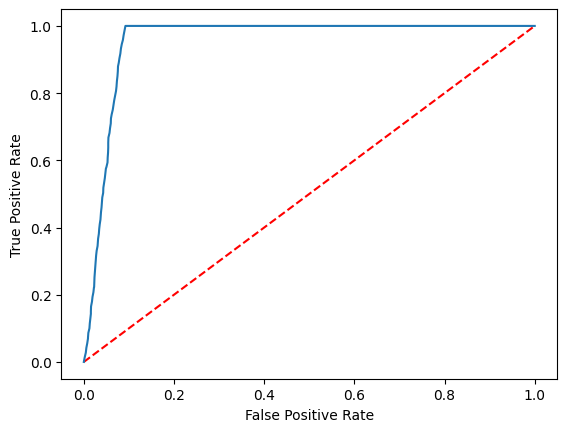

In [23]:
## Plot the ROC curve, no need for pandas as this uses the modelSummary object
modelSummary = lrModel.stages[-1].summary

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(modelSummary.roc.select('FPR').collect(),
         modelSummary.roc.select('TPR').collect())
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()